In [1]:
import numpy as np
import pandas as pd 
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv(r"C:\Users\admin\OneDrive\Documents\weather_data.csv")
df.set_index('Date').sort_index()

columns_of_interest = ['TempAvgF','DewPointAvgF', 'HumidityAvgPercent', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles', 'WindAvgMPH', 'PrecipitationSumInches']
data = df[columns_of_interest]
events = df[['Events']].replace(' ', 'None')

Xem qua thành phần của bộ dữ liệu chúng ta sẽ dùng để phân tích

In [3]:
events

,Events
0,"Rain , Thunderstorm"
1,None
2,None
3,None
4,None
...,...
1314,None
1315,None
1316,None
1317,None


In [4]:
data

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches
0,60,49,75,29.68,7,4,0.46
1,48,36,68,30.13,10,6,0
2,45,27,52,30.49,10,3,0
3,46,28,56,30.45,10,4,0
4,50,40,71,30.33,10,2,T
...,...,...,...,...,...,...,...
1314,89,67,54,29.97,10,5,0
1315,91,64,54,29.9,10,5,0
1316,92,64,51,29.86,10,4,0
1317,93,68,48,29.91,10,4,0


Vẽ đồ thị thể hiện số lượng các sự kiện thời tiết đã xảy ra trong bộ dữ liệu

Text(0.5, 1.0, 'Weather events in dataset')

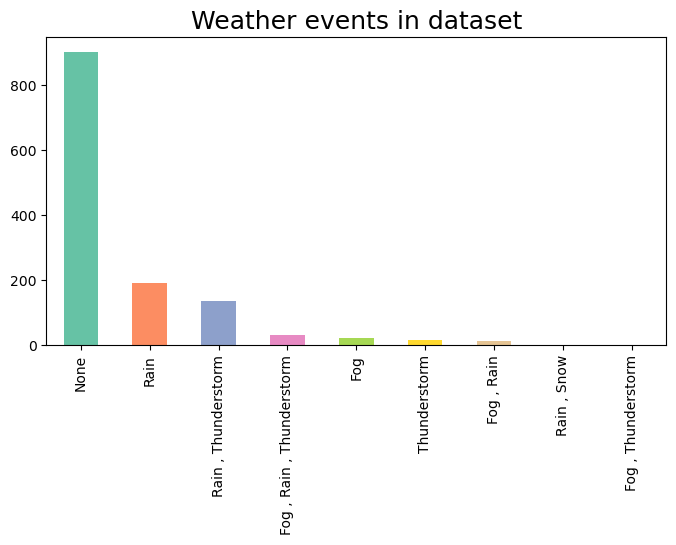

In [5]:
ax = events.Events.value_counts().plot(kind='bar', figsize=(8,4), color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("Weather events in dataset", fontsize=18)

Lọc ra những sự kiện thời tiết đơn lẻ

In [6]:
unique_events = set()
for value in events.Events.value_counts().index:
    splitted = [x.strip() for x in value.split(',')]
    unique_events.update(splitted)
unique_events

{'Fog', 'None', 'Rain', 'Snow', 'Thunderstorm'}

Gán giá trị True cho các sự kiện thời tiết xảy ra tương ứng với từng hàng, ngược lại thì False

In [7]:
def create_event_occurrence_df(events, unique_events):
    single_events = pd.DataFrame()
    for event_type in unique_events:
        event_occurred = events.str.contains(event_type)
        single_events = pd.concat([single_events, pd.DataFrame(data={event_type: event_occurred.values})], join='outer', axis=1)
    return single_events

single_events = create_event_occurrence_df(events.Events, unique_events)
single_events

,Thunderstorm,Snow,None,Fog,Rain
0,True,False,False,False,True
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False
...,...,...,...,...,...
1314,False,False,True,False,False
1315,False,False,True,False,False
1316,False,False,True,False,False
1317,False,False,True,False,False


Vẽ đồ thị thể hiện số lượng của từng sự kiện thời tiết riêng lẻ trong bộ dữ liệu

Text(0.5, 1.0, 'Single weather events in dataset')

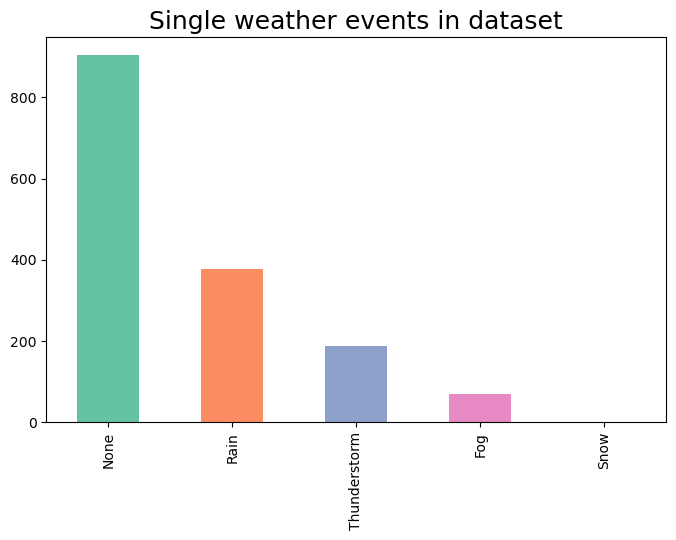

In [8]:
ax = single_events.sum().sort_values(ascending=False).plot.bar(figsize=(8,5), color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("Single weather events in dataset", fontsize=18)

Trong bộ dữ liệu đang sử dụng, có thể thấy ở cột PrecipitationSumInches có các giá trị T bên cạnh những số cụ thể.
Điều này có thể hiểu là vào ngày hôm đó có mưa nhưng không biết cụ thể là bao nhiêu.

In [9]:
precipitation = data[pd.to_numeric(data.PrecipitationSumInches, errors='coerce').isnull()].PrecipitationSumInches.value_counts()
precipitation

T    124
Name: PrecipitationSumInches, dtype: int64

Kiểm tra xem bộ dữ liệu được sử dụng có bao nhiêu hàng không phải là số.

In [10]:
def isColumnNotNumeric(columns_of_interest, data):
    result = np.zeros(data.shape[0], dtype=bool)
    for column_name in columns_of_interest:
        result = result | pd.to_numeric(data[column_name], errors='coerce').isnull()
    return result

def getDataFrameWithNonNumericRows(dataFrame):
    return data[isColumnNotNumeric(columns_of_interest, data)]

non_numeric_rows_count = getDataFrameWithNonNumericRows(data).shape[0]

print("Non numeric rows: {0}".format(non_numeric_rows_count))

Non numeric rows: 134


Chuyển đổi các dòng có T trong cột PrecipitationSumInches thành số 0.
Đồng thời, tạo một cột mới tên PrecipitationTrace để lưu trữ các giả trị T này (gán 1 cho những dòng có T, 0 cho những dòng còn lại)

In [11]:
def numberOrZero(value):
    try:
        parsed = float(value)
        return parsed
    except:
        return 0

#Find rows indices with "T" values
has_precipitation_trace_series = isColumnNotNumeric(['PrecipitationSumInches'], data).astype(int)
data = data.assign(PrecipitationTrace=has_precipitation_trace_series.values)
data['PrecipitationSumInches'] = data['PrecipitationSumInches'].apply(numberOrZero)
data.iloc[0:10,:]

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,60,49,75,29.68,7,4,0.46,0
1,48,36,68,30.13,10,6,0.00,0
2,45,27,52,30.49,10,3,0.00,0
3,46,28,56,30.45,10,4,0.00,0
4,50,40,71,30.33,10,2,0.00,1
5,48,36,63,30.4,9,3,0.00,0
6,53,39,65,30.39,9,1,0.00,1
7,51,39,64,30.17,10,2,0.00,1
8,50,41,76,30.1,10,5,0.00,0
9,40,26,60,30.33,10,5,0.00,0


Từ các output trên, có thể thấy, ngoài cột T thì có nhiều cột khác chứa giá trị không phải số và đã được chuyển thành null.
Vì thế, phải cân nhắc xử lí để mô hình chạy hiệu quả.

In [12]:
getDataFrameWithNonNumericRows(data)

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
174,79,-,75,29.95,-,4,0.0,0
175,92,-,77,29.93,-,6,0.0,0
176,83,-,-,29.9,-,9,0.0,0
177,84,-,72,29.99,-,8,0.0,1
596,89,-,65,-,-,-,0.0,0
597,90,-,62,-,-,6,0.0,0
598,90,-,-,-,-,-,0.0,0
638,82,63,60,29.96,-,3,0.0,0
639,84,64,57,29.95,-,4,0.0,0
741,46,33,60,30.48,-,8,0.0,1


In [13]:
row_indices_for_missing_values = getDataFrameWithNonNumericRows(data).index.values
data_prepared = data.drop(row_indices_for_missing_values)
events_prepared = single_events.drop(row_indices_for_missing_values)
print("Data rows: {0}, Events rows: {1}".format(data_prepared.shape[0], events_prepared.shape[0]))

Data rows: 1307, Events rows: 1307


Vì mô hình của học máy không giám sát nhóm sử dụng được chạy trên các dữ liệu dạng số.
Vì thế, phải kiểm tra xem loại dữ liệu của các cột và ép kiểu nếu cần.

In [14]:
data_prepared.dtypes

TempAvgF                       int64
DewPointAvgF                  object
HumidityAvgPercent            object
SeaLevelPressureAvgInches     object
VisibilityAvgMiles            object
WindAvgMPH                    object
PrecipitationSumInches       float64
PrecipitationTrace             int32
dtype: object

In [15]:
data_prepared = data_prepared.apply(pd.to_numeric)
data_prepared.dtypes

TempAvgF                       int64
DewPointAvgF                   int64
HumidityAvgPercent             int64
SeaLevelPressureAvgInches    float64
VisibilityAvgMiles             int64
WindAvgMPH                     int64
PrecipitationSumInches       float64
PrecipitationTrace             int32
dtype: object

In [16]:
data_prepared

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,60,49,75,29.68,7,4,0.46,0
1,48,36,68,30.13,10,6,0.00,0
2,45,27,52,30.49,10,3,0.00,0
3,46,28,56,30.45,10,4,0.00,0
4,50,40,71,30.33,10,2,0.00,1
...,...,...,...,...,...,...,...,...
1314,89,67,54,29.97,10,5,0.00,0
1315,91,64,54,29.90,10,5,0.00,0
1316,92,64,51,29.86,10,4,0.00,0
1317,93,68,48,29.91,10,4,0.00,0


Bắt đầu chuẩn hóa dữ liệu để huấn luyện mô hình

In [17]:
from sklearn import preprocessing
data_values = data_prepared.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()

data_prepared = pd.DataFrame(min_max_scaler.fit_transform(data_prepared), columns=data_prepared.columns, index=data_prepared.index)

In [18]:
data_prepared.head()

,TempAvgF,DewPointAvgF,HumidityAvgPercent,SeaLevelPressureAvgInches,VisibilityAvgMiles,WindAvgMPH,PrecipitationSumInches,PrecipitationTrace
0,0.484375,0.602941,0.685714,0.109244,0.625,0.272727,0.088462,0.0
1,0.296875,0.411765,0.585714,0.487395,1.000,0.454545,0.000000,0.0
2,0.250000,0.279412,0.357143,0.789916,1.000,0.181818,0.000000,0.0
3,0.265625,0.294118,0.414286,0.756303,1.000,0.272727,0.000000,0.0
4,0.328125,0.470588,0.628571,0.655462,1.000,0.090909,0.000000,1.0


In [19]:
events_prepared.head()

,Thunderstorm,Snow,None,Fog,Rain
0,True,False,False,False,True
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,True,False,False


Chia dữ liệu thành 2 tập riêng biệt để huấn luyện và kiểm thử

In [20]:
from sklearn.model_selection import train_test_split

random_state = 42
X_train, X_test = train_test_split(data_prepared, test_size=0.2, random_state=random_state)
y_train, y_test = train_test_split(events_prepared, test_size=0.2, random_state=random_state)

clusters_count = len(unique_events)

In [21]:
#hàm gán tên từng sự kiện với tên các cụm tương ứng
def create_cluster_mapping(events_prepared, resultDf):
    event_names_ordered = events_prepared.sum().sort_values(ascending=False).index
    clusters_ordered = resultDf.iloc[:,0].value_counts().index
    cluster_category_mapping = {}
    clusters_count = len(clusters_ordered)
    for i in range(clusters_count):
        cluster_category_mapping.update({clusters_ordered[i]:event_names_ordered[i]})
    return cluster_category_mapping

#xem giá trị  dự đoán có đúng vs gtri thực tế
def check_accuracy(X, y):    
    comparison = X == y
    val_counts = comparison.all(axis=1).value_counts()
    percentageCorrect = val_counts.at[True] / X.shape[0] * 100
    return percentageCorrect
y_train_col_ordered = y_train.reindex(sorted(y_train.columns), axis=1)

Sử dụng những thuật toán phân cụm và so sánh với kết quả thực tế. Từ đó, đưa ra thuật toán cho kết quả gần với thực tế nhất.

Text(0.5, 1.0, 'K-Means clustering')

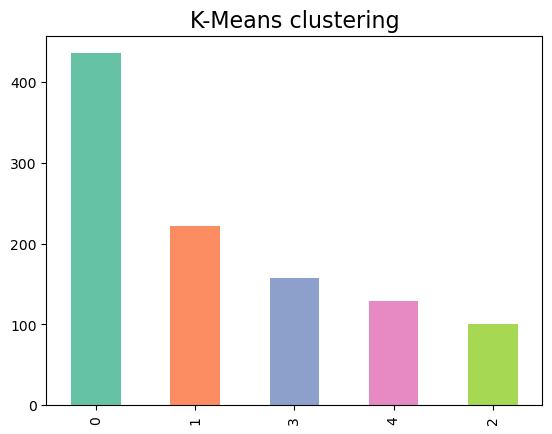

In [22]:
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")
kmeans = KMeans(n_clusters=clusters_count).fit(X_train)
resultDf1 = pd.DataFrame(kmeans.labels_)
resultDf1.index = X_train.index
ax = resultDf1.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("K-Means clustering", fontsize=16)

In [23]:
resultDf1.replace(create_cluster_mapping(y_train, resultDf1), inplace=True)
result_kmean = create_event_occurrence_df(resultDf1[0], unique_events)
result_kmean.index = resultDf1.index
result_kmean.reindex(sorted(result_kmean.columns), axis=1)
result_kmean.sort_index()

,Thunderstorm,Snow,None,Fog,Rain
0,True,False,False,False,False
1,False,False,False,True,False
2,False,False,False,True,False
3,False,False,False,True,False
4,False,True,False,False,False
...,...,...,...,...,...
1312,False,False,True,False,False
1313,False,True,False,False,False
1315,False,False,True,False,False
1316,False,False,True,False,False


In [24]:
result_kmean = result_kmean.reindex(sorted(result_kmean.columns), axis=1)
a = check_accuracy(result_kmean.sort_index(), y_train_col_ordered.sort_index())

Text(0.5, 1.0, 'Spectral Clustering')

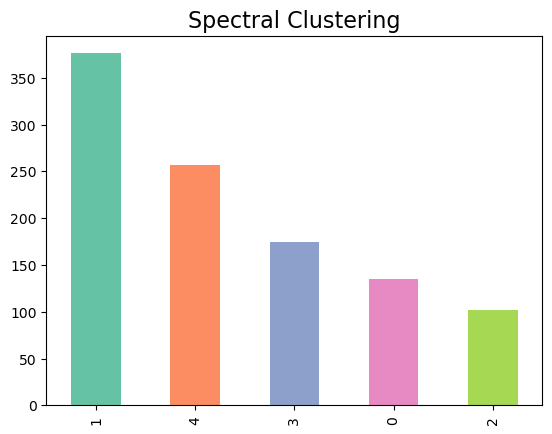

In [25]:
from sklearn.cluster import SpectralClustering
warnings.filterwarnings("ignore")
sc = SpectralClustering(n_clusters=clusters_count).fit(X_train)
resultDf2 = pd.DataFrame(sc.labels_)
resultDf2.index = X_train.index
ax = resultDf2.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("Spectral Clustering", fontsize=16)

In [26]:
resultDf2.replace(create_cluster_mapping(y_train, resultDf2), inplace=True)
result_spectral = create_event_occurrence_df(resultDf2[0], unique_events)
result_spectral.index = resultDf2.index
result_spectral.reindex(sorted(result_spectral.columns), axis=1)
result_spectral.sort_index()

,Thunderstorm,Snow,None,Fog,Rain
0,False,False,False,True,False
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,False,True,False,False,False
...,...,...,...,...,...
1312,False,False,False,False,True
1313,False,True,False,False,False
1315,False,False,True,False,False
1316,False,False,True,False,False


In [27]:
result_spectral = result_spectral.reindex(sorted(result_spectral.columns), axis=1)
b = check_accuracy(result_spectral.sort_index(), y_train_col_ordered.sort_index())

Text(0.5, 1.0, 'DBSCAN')

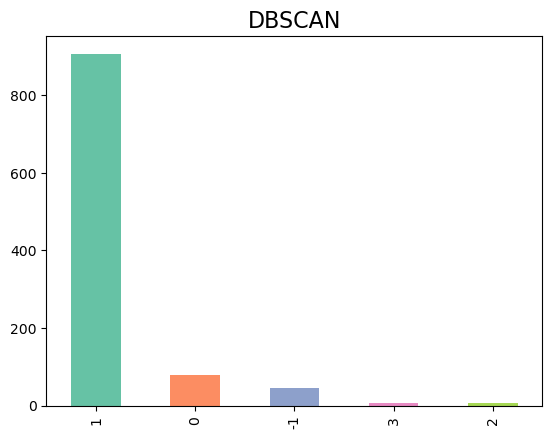

In [28]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=4).fit(X_train)
resultDf3 = pd.DataFrame(dbscan.labels_)
resultDf3.index = X_train.index
ax = resultDf3.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("DBSCAN", fontsize=16)

In [29]:
resultDf3.replace(create_cluster_mapping(y_train, resultDf3), inplace=True)
result_dbscan = create_event_occurrence_df(resultDf3[0], unique_events)
result_dbscan.index = resultDf3.index
result_dbscan.reindex(sorted(result_dbscan.columns), axis=1)
result_dbscan.sort_index()

,Thunderstorm,Snow,None,Fog,Rain
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,True,False,False,False
...,...,...,...,...,...
1312,False,False,True,False,False
1313,False,False,False,False,True
1315,False,False,True,False,False
1316,False,False,True,False,False


In [30]:
result_dbscan = result_dbscan.reindex(sorted(result_dbscan.columns), axis=1)
c = check_accuracy(result_dbscan.sort_index(), y_train_col_ordered.sort_index())

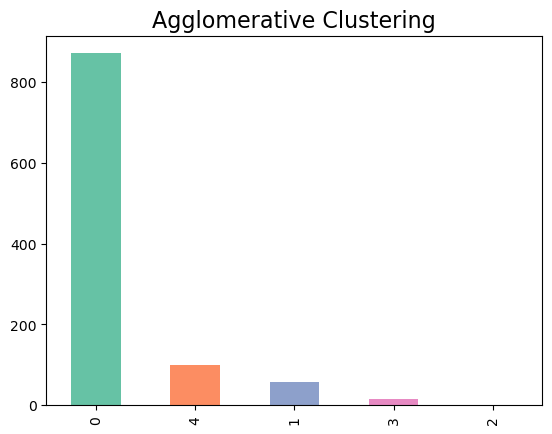

In [31]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=clusters_count, linkage="average").fit(X_train)
resultDf = pd.DataFrame(ac.labels_)
ax = resultDf.iloc[:,0].value_counts().plot.bar(color = plt.cm.Set2(range(len(events.Events.unique()))))
ax.set_title("Agglomerative Clustering", fontsize=16)
resultDf4 = resultDf.copy()
resultDf4.index = X_train.index

In [32]:
resultDf4.replace(create_cluster_mapping(y_train, resultDf4), inplace=True)
result_agglo = create_event_occurrence_df(resultDf4[0], unique_events)
result_agglo.index = resultDf4.index
result_agglo.reindex(sorted(result_agglo.columns), axis=1)
result_agglo.sort_index()

,Thunderstorm,Snow,None,Fog,Rain
0,False,False,True,False,False
1,False,False,True,False,False
2,False,False,True,False,False
3,False,False,True,False,False
4,False,False,False,False,True
...,...,...,...,...,...
1312,False,False,True,False,False
1313,False,False,False,False,True
1315,False,False,True,False,False
1316,False,False,True,False,False


In [33]:
result_agglo = result_agglo.reindex(sorted(result_agglo.columns), axis=1)
d = check_accuracy(result_agglo.sort_index(), y_train_col_ordered.sort_index())

In [34]:
accuracy_df = {'K-means': a, 'Spectral': b, 'DBSCAN': c, 'Agglomerative': d}
accuracy_df = pd.DataFrame(accuracy_df, index = ['Accuracy'])
accuracy_df

,K-means,Spectral,DBSCAN,Agglomerative
Accuracy,32.91866,30.143541,66.028708,66.985646


Có thể thấy, thuật toán phân cụm Agglomerative đem lại kết quả phân cụm gần với thực tế nhất.

<Axes: title={'center': 'Bar obtained from agglomerative clustering'}>

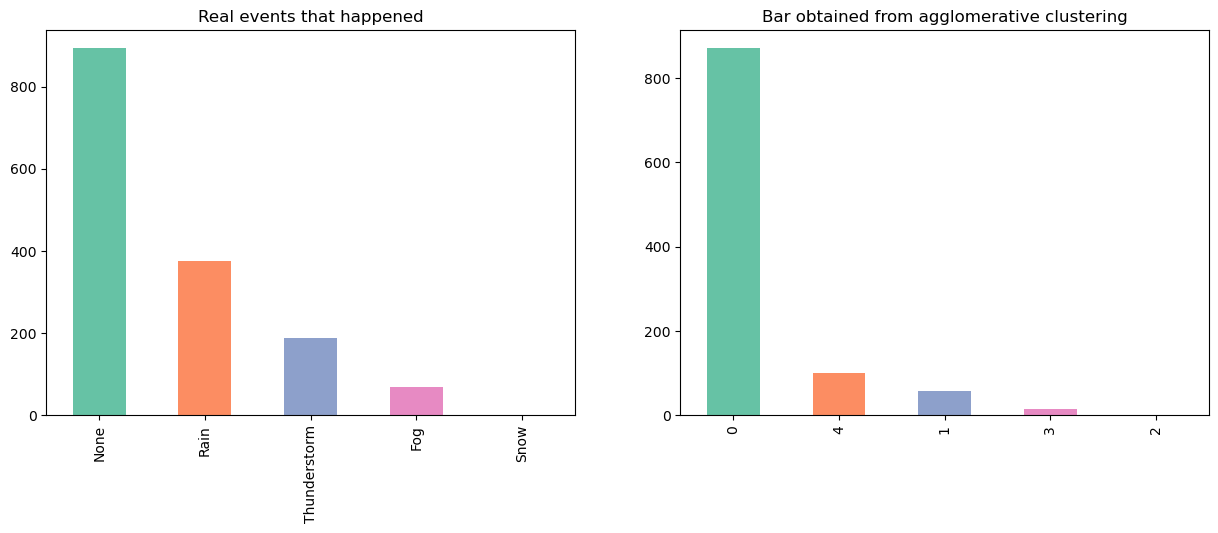

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
events_prepared.sum().sort_values(ascending=False).plot.bar(ax=ax[0], title="Real events that happened", color = plt.cm.Set2(range(len(events.Events.unique()))))
resultDf.iloc[:,0].value_counts().plot.bar(ax=ax[1], title="Bar obtained from agglomerative clustering", color = plt.cm.Set2(range(len(events.Events.unique()))))

Thực hiện gán tên cụm vào tên sự kiện thời tiết tương ứng. 
Sau đó, sử dụng lý thuyết phân cụm của thuật toán Agglomerative để xem rằng liệu 1 ngày có thể có 2 sự kiện thời tiết hay không.

In [36]:
cluster_category_mapping = create_cluster_mapping(y_test, resultDf)

In [37]:
#tọa độ tâm từng cụm
cluster_centers_mapping = {}
for key in cluster_category_mapping:
    cluster_indices = resultDf.loc[resultDf[0] == key].index
    cluster_data = X_train.iloc[cluster_indices]
    mean = cluster_data.mean(axis=0).values
    #print("\n" + cluster_category_mapping[key])
    #print(mean)
    cluster_centers_mapping.update({key:mean})
cluster_centers_mapping

{0: array([0.66684626, 0.71558485, 0.53737274, 0.39408867, 0.92715517,
        0.36185998, 0.01333112, 0.        ]),
 4: array([0.66259282, 0.7603378 , 0.62192362, 0.39995008, 0.9220297 ,
        0.39423942, 0.        , 1.        ]),
 1: array([0.37553879, 0.59077079, 0.81453202, 0.46479281, 0.47844828,
        0.40125392, 0.06999337, 0.        ]),
 3: array([0.690625  , 0.88431373, 0.85142857, 0.28403361, 0.46666667,
        0.44242424, 0.59641026, 0.        ]),
 2: array([0.015625  , 0.05882353, 0.3       , 0.83193277, 1.        ,
        0.36363636, 0.        , 1.        ])}

In [38]:
#tính khoảng cách từ 1 điểm đến tâm từng cụm
def get_distances_from_cluster(data_frame):
    cluster_distance = np.zeros((data_frame.shape[0], clusters_count))
    #khoảng cách euclidean
    for i in range(data_frame.shape[0]):
        for key in cluster_category_mapping:
            dist = np.linalg.norm(data_frame.iloc[[i]].values[0]-cluster_centers_mapping[key])
            cluster_distance[i,key] = dist
            #print(dist)
    column_names = [cluster_category_mapping[k] for k in cluster_category_mapping]
    #column_names

    return pd.DataFrame(cluster_distance, index=data_frame.index, columns=column_names)

distancesDf = get_distances_from_cluster(X_train)
distancesDf.sort_index().head()

,None,Rain,Thunderstorm,Fog,Snow
0,0.503997,0.439705,1.530869,0.701142,1.120684
1,0.504285,0.608979,1.188391,1.063296,1.128684
2,0.768810,0.867572,1.068494,1.329796,1.294182
3,0.705968,0.799183,1.070004,1.269659,1.251355
4,1.153381,1.208659,0.693316,1.501303,0.599369


In [39]:
def classify_events(distances_dataFrame):
    return distances_dataFrame.apply(lambda x: x<x.min()*1.01, axis=1)

Đánh giá mô hình phân cụm dựa trên tỷ lệ giữa số dòng dự báo đúng và tổng số dòng của 2 tập X_train và X_test

Chỉ số Accuracy của mô hình là 64.97607655502392


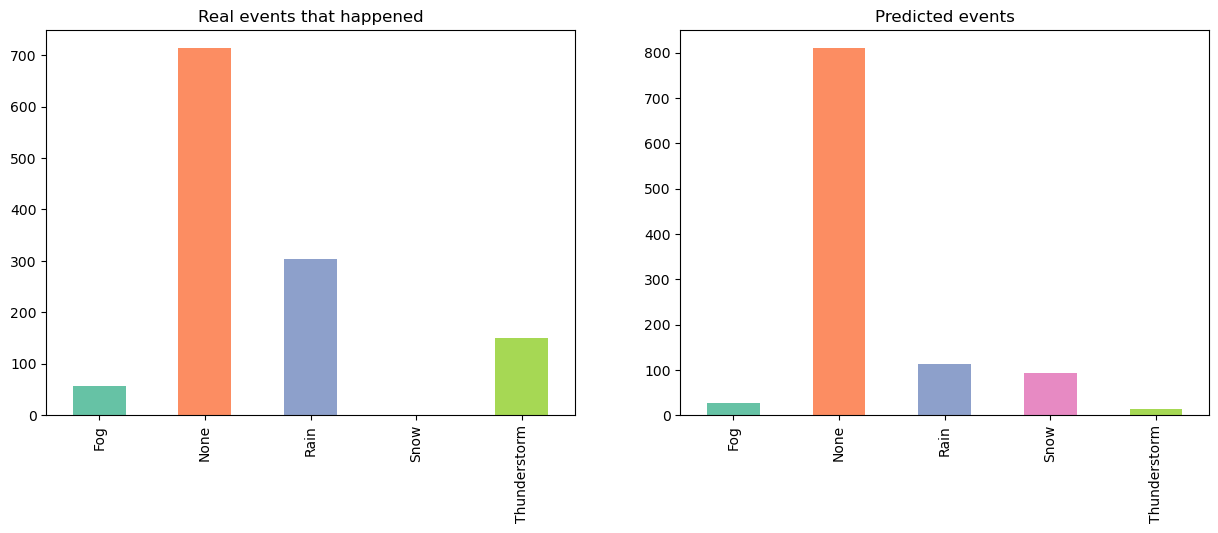

In [40]:
classification_result = classify_events(distancesDf)
X_train_col_ordered = classification_result.reindex(sorted(classification_result.columns), axis=1)
y_train_col_ordered = y_train.reindex(sorted(y_train.columns), axis=1)
a = check_accuracy(X_train_col_ordered, y_train_col_ordered)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_train_col_ordered.sum().plot.bar(ax=ax[0], title="Real events that happened", color = plt.cm.Set2(range(len(events.Events.unique()))))
ax = X_train_col_ordered.sum().plot.bar(ax=ax[1], title="Predicted events", color = plt.cm.Set2(range(len(events.Events.unique()))))
#resultDf.iloc[:,0].value_counts().plot.bar(ax=ax[1], title="Histogram obtained from agglomerative clustering")
print(f'Chỉ số Accuracy của mô hình là {a}')

Chỉ số Accuracy của mô hình là 70.22900763358778


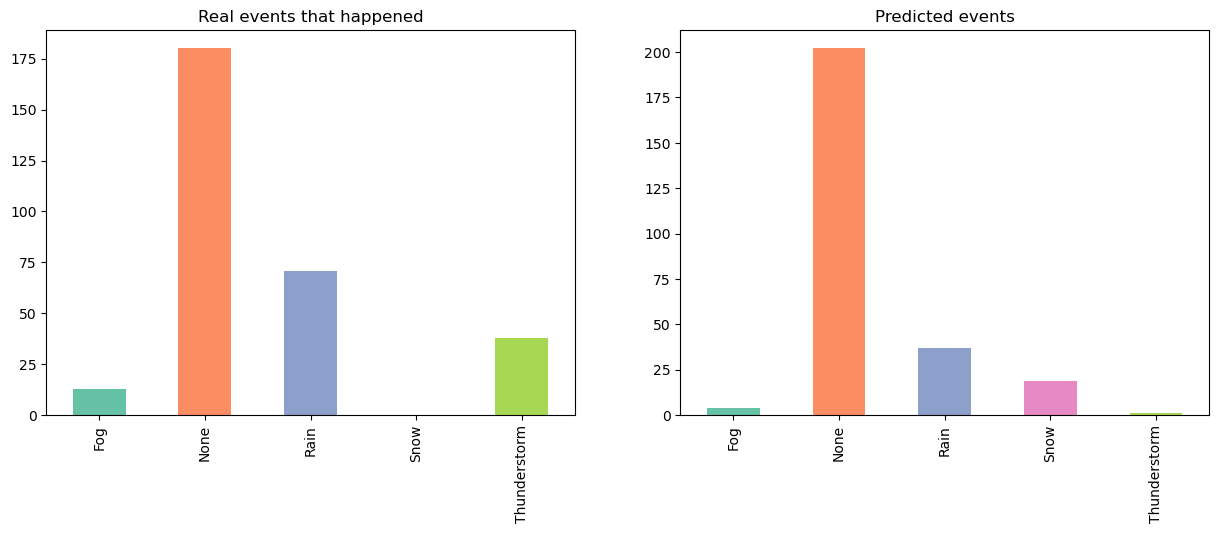

In [41]:
distancesDf = get_distances_from_cluster(X_test)
classification_result = classify_events(distancesDf)
X_test_col_ordered = classification_result.reindex(sorted(classification_result.columns), axis=1)
y_test_col_ordered = y_test.reindex(sorted(y_train.columns), axis=1)
a = check_accuracy(X_test_col_ordered, y_test_col_ordered)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
y_test_col_ordered.sum().plot.bar(ax=ax[0], title="Real events that happened", color = plt.cm.Set2(range(len(events.Events.unique()))))
X_test_col_ordered.sum().plot.bar(ax=ax[1], title="Predicted events", color = plt.cm.Set2(range(len(events.Events.unique()))))
print(f'Chỉ số Accuracy của mô hình là {a}')